In [1]:
%matplotlib inline
import matplotlib
from plots import big_fontsize, fig_width, fontsize
from flarestack.utils.neutrino_cosmology import calculate_transient_cosmology
from astropy import units as u
import matplotlib.pyplot as plt
from flarestack.shared import plot_output_dir
import numpy as np
import os
from flarestack.misc.convert_diffuse_flux_contour import contour_95, \
    upper_contour, lower_contour, global_fit_e_range
from flarestack.utils.neutrino_cosmology import get_diffuse_flux_at_1GeV
import logging
from flarestack.analyses.ccsn.stasik_2017.sn_cosmology import ccsn_madau

In [2]:
logging.getLogger().setLevel("INFO")

In [3]:
e_bran = 10**50 * u.erg
e_tot = e_bran / 0.16
e_mean = e_tot/17.
print(e_mean)

3.676470588235294e+49 erg


INFO:root:Using the northern_tracks_19 best fit values of the diffuse flux.
INFO:root:Diffuse Flux at 1 GeV: 4.058471421020815e-07 1 / (cm2 GeV s sr)
INFO:root:Diffuse Spectral Index is 2.29
INFO:root:Minimum Energy is 100000 GeV.
INFO:root:Maximum Energy is 10000000 GeV
INFO:root:BranTDEs
INFO:root:Neutrino Energy is 3.676470588235294e+49 erg
INFO:root:Rate is 8e-07 1 / (Mpc3 yr)
INFO:root:Cumulative sources at z=8.0: 8.235E+04
INFO:root:Cumulative flux at z=8.0 (1 GeV): 1.136E-06 1 / (cm2 GeV s sr)
INFO:root:Cumulative annual flux at z=8.0 (1 GeV): 3.585E+01 1 / (cm2 GeV sr)
INFO:root:Fraction of diffuse flux at 1GeV: 2.8
INFO:root:Cumulative neutrino flux 1.1361201386712302e-06 1 / (cm2 GeV s sr)
INFO:root:Fraction from nearby (z<0.15) sources: 0.39908632501430297
INFO:root:Fraction from nearby (z<0.3) sources: 0.6478208162630199


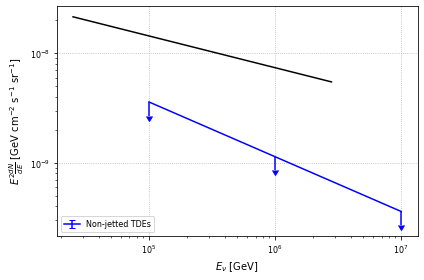

In [4]:
# e_pdf_dict_template = {
#     "energy_pdf_name": "power_law",
#     "e_min_gev": 2 * 10**5,
#     "e_max_gev": 10**6,
#     "gamma": 2.0
# }

e_pdf_dict_template = {
    "energy_pdf_name": "power_law",
    "e_min_gev": 10**5,
    "e_max_gev": 10**7,
    "gamma": 2.5
}

diffuse_fit = "northern_tracks_19"

# Assumed source evolution is highly negative
non_jetted_m = 0

eta = -2


def raw_tde_evolution(z):
    """https://arxiv.org/abs/1509.01592"""
    evolution = ((1 + z)**(0.2 * eta) + ((1 + z)/1.43)**(-3.2 * eta) +
                 ((1 + z)/2.66)**(-7 * eta)
                 )**(1./eta)
    return evolution

# raw_tde_evolution = ccsn_madau


def normed_tde_evolution(z):
    """TDE evolution, scaled such that normed_evolution(0) = 1. This function
    can then be multiplied by the local TDE density to give overall TDE
    redshift evolution

    :param z: Redshift
    :return: Normalised scaling of density with redshift
    """
    return raw_tde_evolution(z) / raw_tde_evolution(0.0)



def tde_rate(z):
    """TDE rate as a function of redshift, equal to the local density
    multiplied by the redshift evolution of the density. Rate is derived
    from https://arxiv.org/pdf/1707.03458

    :param z: Redshift
    :return: TDE rate at redshift z
    """
    return (normed_tde_evolution(z) * 8 * 10**-7) / (u.Mpc**3 * u.yr)


def theoretical_tde_rate(z):
    """Optimistic TDE rate from https://arxiv.org/pdf/1601.06787 as a function
    of redshift, equal to the local density multiplied by the redshift
    evolution of the density

    :param z: Redshift
    :return: TDE rate at redshift z
    """
    return (normed_tde_evolution(z) * 1.5 * 10**-6) / (u.Mpc**3 * u.yr)


res = [
    ("Bran", e_mean, "Non-jetted TDEs"),
    # ("obscured", 4.5*10**51 * u.erg),
    # ("silver", 3 * 10**49 * u.erg)
]

norms = dict()

for (name, energy, key) in res:

    class_dict = dict()

    # for i, rate in enumerate([tde_rate, theoretical_tde_rate]):
    for i, rate in enumerate([tde_rate]):
        e_pdf_dict = dict(e_pdf_dict_template)
        e_pdf_dict["source_energy_erg"] = energy

        rate_key = ["(Observed Rate)", "(Theoretical Rate)"][i]

        class_dict[rate_key] = calculate_transient_cosmology(e_pdf_dict, rate,
                                                             name + "TDEs",
                                                             zmax=6.0, diffuse_fit=diffuse_fit)

    norms[key] = class_dict


base_dir = "plots/"

e_range = np.logspace(np.log10(e_pdf_dict_template["e_min_gev"]), np.log10(e_pdf_dict_template["e_max_gev"]), 3)


plt.figure()

# Plot 95% contour

# plt.fill_between(
#     global_fit_e_range,
#     global_fit_e_range ** 2 * upper_contour(global_fit_e_range, contour_95),
#     global_fit_e_range ** 2 * lower_contour(global_fit_e_range, contour_95),
#     color="k", label='IceCube diffuse flux\nApJ 809, 2015',
#     alpha=.5,
# )

diffuse_norm, diffuse_gamma = get_diffuse_flux_at_1GeV(diffuse_fit)


plt.plot(global_fit_e_range,
         diffuse_norm * global_fit_e_range**(2. - diffuse_gamma),
         color="k")

linestyles = {
    "(Observed Rate)": "-",
    "(Theoretical Rate)": ":"
}

try:
    gamma = e_pdf_dict_template["gamma"]
except KeyError:
    gamma = diffuse_gamma

def z(energy, norm):
    return norm * energy ** (2. - gamma)



for i, (name, res_dict) in enumerate(norms.items()):
    # plt.plot(e_range, z(e_range, norm), label=name)
    for (rate, norm) in res_dict.items():
        plt.errorbar(e_range, z(e_range, norm).value,
                     yerr=.25 * np.array([x.value for x in z(e_range, norm)]),
                     uplims=True, label=name,
                     linestyle = linestyles[rate],
                     color=["blue", "orange"][i])

plt.yscale("log")
plt.xscale("log")
plt.legend(loc="lower left")
# plt.title(r"Contribution of TDEs to the Diffuse Neutrino Flux")
plt.ylabel(r"$E^{2}\frac{dN}{dE}$ [GeV cm$^{-2}$ s$^{-1}$ sr$^{-1}$]")
plt.xlabel(r"$E_{\nu}$ [GeV]")
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.savefig(base_dir + "diffuse_flux_global_fit.pdf")